In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

data = pd.read_csv("/home/mw/.cache/kagglehub/datasets/yasserh/housing-prices-dataset/versions/1/Housing.csv")
data = data.dropna()

categorical_columns = data.select_dtypes(include=['object']).columns
print(categorical_columns)

# Apply one-hot encoding for categorical columns
for col in categorical_columns:
    if data[col].nunique() <= 2:
        data[col] = LabelEncoder().fit_transform(data[col])
    else:
        one_hot = pd.get_dummies(data[col], prefix=col)
        data = pd.concat([data.drop(col, axis=1), one_hot], axis=1)

boolean_columns = data.select_dtypes(include='bool').columns
data[boolean_columns] = data[boolean_columns].astype(int)

numeric_columns = data.select_dtypes(include=['float64']).columns
scaler = StandardScaler()
# data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Optionally, standardize target
target_column = "price"
target = data[target_column]
target = (target - target.mean()) / target.std()

data['area_standardized'] = (data['area'] - data['area'].mean()) / data['area'].std()
data['bedrooms_standardized'] = (data['bedrooms'] - data['bedrooms'].mean()) / data['bedrooms'].std()
data['bathrooms_standardized'] = (data['bathrooms'] - data['bathrooms'].mean()) / data['bathrooms'].std()
data['stories_standardized'] = (data['stories'] - data['stories'].mean()) / data['stories'].std()
data['parking_standardized'] = (data['parking'] - data['parking'].mean()) / data['parking'].std()

# Remove original columns after standardizing
data = data.drop(columns=['area', 'bedrooms', 'bathrooms', 'stories', 'parking', target_column])

features = data
print(features.head())

features_tensor = torch.tensor(features.values, dtype=torch.float32)
target_tensor = torch.tensor(target.values, dtype=torch.float32).unsqueeze(1)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
print(data.columns)


Index(['mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioning', 'prefarea', 'furnishingstatus'],
      dtype='object')
   mainroad  guestroom  basement  hotwaterheating  airconditioning  prefarea  \
0         1          0         0                0                1         1   
1         1          0         0                0                1         0   
2         1          0         1                0                0         1   
3         1          0         1                0                1         1   
4         1          1         1                0                1         0   

   furnishingstatus_furnished  furnishingstatus_semi-furnished  \
0                           1                                0   
1                           1                                0   
2                           0                                1   
3                           1                                0   
4                           1                

In [2]:
print(y_train_tensor.shape)

torch.Size([436, 1])


In [8]:
import torch
from collections import Counter
from sklearn.model_selection import train_test_split

# Identify the problematic class
class_counts = Counter(target_tensor.numpy().flatten())
problematic_class = [k for k, v in class_counts.items() if v < 2]

# Filter out samples with the problematic class
mask = ~torch.isin(target_tensor, torch.tensor(problematic_class))

# Ensure mask is 1D (flatten it if necessary)
mask = mask.flatten()

filtered_features = features_tensor[mask]
filtered_targets = target_tensor[mask]

# Use the filtered dataset
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
    filtered_features, filtered_targets, test_size=0.3, random_state=42, stratify=filtered_targets
)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, condition_dim):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(input_dim + condition_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc_mean = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.LeakyRelu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, condition):
        # print("x ", x.shape)
        x = torch.cat([x, condition], dim=-1)  # Concatenate the condition to the input
        # print("concat :",x.shape )
        x = self.LeakyRelu(self.fc1(x))
        x = self.dropout(self.LeakyRelu(self.fc2(x)))
        x = self.LeakyRelu(self.fc3(x))
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        return mean, log_var

In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim):
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(latent_dim + condition_dim, 128)  # Latent + condition
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc_output = nn.Linear(512, output_dim)
        self.lrelu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, z, condition):
        z = torch.cat([z, condition], dim=-1)  # Concatenate the condition to the latent
        z = self.lrelu(self.fc1(z))
        z = self.dropout(self.lrelu(self.fc2(z)))
        z = self.lrelu(self.fc3(z))
        reconstructed_x = self.sigmoid(self.fc_output(z))
        return reconstructed_x

In [11]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, condition_dim,beta = 0.1):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim, condition_dim)
        self.decoder = Decoder(latent_dim, input_dim, condition_dim)
        self.beta = nn.Parameter(torch.tensor(1.0))

    def forward(self, x, condition):
        mu, log_var = self.encoder(x, condition)
        z = self.reparameterize(mu, log_var)
        reconstructed_x = self.decoder(z, condition)
        return reconstructed_x, mu, log_var

    @staticmethod
    def reparameterize(mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:05, 19.23it/s]

Epoch [1/100], Loss: 36.4984
Epoch [1/100], Train Loss: 36.4984, Val Loss: 16.6373
Epoch [2/100], Loss: 16.2405
Epoch [2/100], Train Loss: 16.2405, Val Loss: 10.1439
Epoch [3/100], Loss: 10.3962
Epoch [3/100], Train Loss: 10.3962, Val Loss: 6.3435
Epoch [4/100], Loss: 6.6858
Epoch [4/100], Train Loss: 6.6858, Val Loss: 3.4334
Epoch [5/100], Loss: 4.5413


 11%|█         | 11/100 [00:00<00:01, 57.40it/s]

Epoch [5/100], Train Loss: 4.5413, Val Loss: 2.3821
Epoch [6/100], Loss: 3.1986
Epoch [6/100], Train Loss: 3.1986, Val Loss: 1.6772
Epoch [7/100], Loss: 2.4601
Epoch [7/100], Train Loss: 2.4601, Val Loss: 1.2689
Epoch [8/100], Loss: 1.9417
Epoch [8/100], Train Loss: 1.9417, Val Loss: 1.0570
Epoch [9/100], Loss: 1.6279
Epoch [9/100], Train Loss: 1.6279, Val Loss: 0.7855
Epoch [10/100], Loss: 1.4107
Epoch [10/100], Train Loss: 1.4107, Val Loss: 0.8590
Epoch [11/100], Loss: 1.2492
Epoch [11/100], Train Loss: 1.2492, Val Loss: 0.6383
Epoch [12/100], Loss: 1.0964
Epoch [12/100], Train Loss: 1.0964, Val Loss: 0.6843
Epoch [13/100], Loss: 1.0179
Epoch [13/100], Train Loss: 1.0179, Val Loss: 0.5753
Epoch [14/100], Loss: 0.9293
Epoch [14/100], Train Loss: 0.9293, Val Loss: 0.5330
Epoch [15/100], Loss: 0.8598
Epoch [15/100], Train Loss: 0.8598, Val Loss: 0.5448
Epoch [16/100], Loss: 0.8169
Epoch [16/100], Train Loss: 0.8169, Val Loss: 0.5032
Epoch [17/100], Loss: 0.7796
Epoch [17/100], Train Los

 20%|██        | 20/100 [00:00<00:01, 69.39it/s]

Epoch [18/100], Loss: 0.7542
Epoch [18/100], Train Loss: 0.7542, Val Loss: 0.4877
Epoch [19/100], Loss: 0.7127
Epoch [19/100], Train Loss: 0.7127, Val Loss: 0.4738
Epoch [20/100], Loss: 0.6961
Epoch [20/100], Train Loss: 0.6961, Val Loss: 0.4623
Epoch [21/100], Loss: 0.6816


 28%|██▊       | 28/100 [00:00<00:01, 70.65it/s]

Epoch [21/100], Train Loss: 0.6816, Val Loss: 0.4521
Epoch [22/100], Loss: 0.6699
Epoch [22/100], Train Loss: 0.6699, Val Loss: 0.4406
Epoch [23/100], Loss: 0.6576
Epoch [23/100], Train Loss: 0.6576, Val Loss: 0.4346
Epoch [24/100], Loss: 0.6387
Epoch [24/100], Train Loss: 0.6387, Val Loss: 0.4308
Epoch [25/100], Loss: 0.6301
Epoch [25/100], Train Loss: 0.6301, Val Loss: 0.4247
Epoch [26/100], Loss: 0.6373
Epoch [26/100], Train Loss: 0.6373, Val Loss: 0.4245
Epoch [27/100], Loss: 0.6207
Epoch [27/100], Train Loss: 0.6207, Val Loss: 0.4227
Epoch [28/100], Loss: 0.6271
Epoch [28/100], Train Loss: 0.6271, Val Loss: 0.4227
Epoch [29/100], Loss: 0.6125
Epoch [29/100], Train Loss: 0.6125, Val Loss: 0.4164
Epoch [30/100], Loss: 0.6116
Epoch [30/100], Train Loss: 0.6116, Val Loss: 0.4169
Epoch [31/100], Loss: 0.6106


 28%|██▊       | 28/100 [00:00<00:01, 70.65it/s]

Epoch [31/100], Train Loss: 0.6106, Val Loss: 0.4159
Epoch [32/100], Loss: 0.6181
Epoch [32/100], Train Loss: 0.6181, Val Loss: 0.4188
Epoch [33/100], Loss: 0.6037
Epoch [33/100], Train Loss: 0.6037, Val Loss: 0.4146
Epoch [34/100], Loss: 0.6133


 47%|████▋     | 47/100 [00:00<00:00, 78.36it/s]

Epoch [34/100], Train Loss: 0.6133, Val Loss: 0.4094
Epoch [35/100], Loss: 0.6055
Epoch [35/100], Train Loss: 0.6055, Val Loss: 0.4081
Epoch [36/100], Loss: 0.5981
Epoch [36/100], Train Loss: 0.5981, Val Loss: 0.4094
Epoch [37/100], Loss: 0.5916
Epoch [37/100], Train Loss: 0.5916, Val Loss: 0.4124
Epoch [38/100], Loss: 0.5956
Epoch [38/100], Train Loss: 0.5956, Val Loss: 0.4093
Epoch [39/100], Loss: 0.6046
Epoch [39/100], Train Loss: 0.6046, Val Loss: 0.4052
Epoch [40/100], Loss: 0.6073
Epoch [40/100], Train Loss: 0.6073, Val Loss: 0.4079
Epoch [41/100], Loss: 0.6062
Epoch [41/100], Train Loss: 0.6062, Val Loss: 0.4001
Epoch [42/100], Loss: 0.5943
Epoch [42/100], Train Loss: 0.5943, Val Loss: 0.4029
Epoch [43/100], Loss: 0.5925
Epoch [43/100], Train Loss: 0.5925, Val Loss: 0.4047
Epoch [44/100], Loss: 0.6090
Epoch [44/100], Train Loss: 0.6090, Val Loss: 0.4039
Epoch [45/100], Loss: 0.5879
Epoch [45/100], Train Loss: 0.5879, Val Loss: 0.3947
Epoch [46/100], Loss: 0.5893
Epoch [46/100], 

 47%|████▋     | 47/100 [00:00<00:00, 78.36it/s]

Epoch [51/100], Loss: 0.5945
Epoch [51/100], Train Loss: 0.5945, Val Loss: 0.3906
Epoch [52/100], Loss: 0.5931
Epoch [52/100], Train Loss: 0.5931, Val Loss: 0.3841
Epoch [53/100], Loss: 0.5756
Epoch [53/100], Train Loss: 0.5756, Val Loss: 0.3944
Epoch [54/100], Loss: 0.5839
Epoch [54/100], Train Loss: 0.5839, Val Loss: 0.3933
Epoch [55/100], Loss: 0.5839


 67%|██████▋   | 67/100 [00:00<00:00, 82.86it/s]

Epoch [55/100], Train Loss: 0.5839, Val Loss: 0.3859
Epoch [56/100], Loss: 0.5910
Epoch [56/100], Train Loss: 0.5910, Val Loss: 0.3881
Epoch [57/100], Loss: 0.5803
Epoch [57/100], Train Loss: 0.5803, Val Loss: 0.3850
Epoch [58/100], Loss: 0.5802
Epoch [58/100], Train Loss: 0.5802, Val Loss: 0.3804
Epoch [59/100], Loss: 0.5721
Epoch [59/100], Train Loss: 0.5721, Val Loss: 0.3786
Epoch [60/100], Loss: 0.5789
Epoch [60/100], Train Loss: 0.5789, Val Loss: 0.3715
Epoch [61/100], Loss: 0.5749
Epoch [61/100], Train Loss: 0.5749, Val Loss: 0.3694
Epoch [62/100], Loss: 0.5828
Epoch [62/100], Train Loss: 0.5828, Val Loss: 0.3721
Epoch [63/100], Loss: 0.5767
Epoch [63/100], Train Loss: 0.5767, Val Loss: 0.3657
Epoch [64/100], Loss: 0.5845
Epoch [64/100], Train Loss: 0.5845, Val Loss: 0.3782
Epoch [65/100], Loss: 0.5800
Epoch [65/100], Train Loss: 0.5800, Val Loss: 0.3702
Epoch [66/100], Loss: 0.5832
Epoch [66/100], Train Loss: 0.5832, Val Loss: 0.3647
Epoch [67/100], Loss: 0.5765
Epoch [67/100], 

 67%|██████▋   | 67/100 [00:00<00:00, 82.86it/s]

Epoch [68/100], Loss: 0.5686
Epoch [68/100], Train Loss: 0.5686, Val Loss: 0.3591
Epoch [69/100], Loss: 0.5756
Epoch [69/100], Train Loss: 0.5756, Val Loss: 0.3727
Epoch [70/100], Loss: 0.5689
Epoch [70/100], Train Loss: 0.5689, Val Loss: 0.3568
Epoch [71/100], Loss: 0.5764
Epoch [71/100], Train Loss: 0.5764, Val Loss: 0.3664


 76%|███████▌  | 76/100 [00:01<00:00, 80.20it/s]

Epoch [72/100], Loss: 0.5696
Epoch [72/100], Train Loss: 0.5696, Val Loss: 0.3515
Epoch [73/100], Loss: 0.5741
Epoch [73/100], Train Loss: 0.5741, Val Loss: 0.3577
Epoch [74/100], Loss: 0.5739
Epoch [74/100], Train Loss: 0.5739, Val Loss: 0.3639
Epoch [75/100], Loss: 0.5763
Epoch [75/100], Train Loss: 0.5763, Val Loss: 0.3577
Epoch [76/100], Loss: 0.5634
Epoch [76/100], Train Loss: 0.5634, Val Loss: 0.3576
Epoch [77/100], Loss: 0.5609
Epoch [77/100], Train Loss: 0.5609, Val Loss: 0.3547
Epoch [78/100], Loss: 0.5755
Epoch [78/100], Train Loss: 0.5755, Val Loss: 0.3642
Epoch [79/100], Loss: 0.5584
Epoch [79/100], Train Loss: 0.5584, Val Loss: 0.3566
Epoch [80/100], Loss: 0.5702
Epoch [80/100], Train Loss: 0.5702, Val Loss: 0.3654
Epoch [81/100], Loss: 0.5681
Epoch [81/100], Train Loss: 0.5681, Val Loss: 0.3674
Epoch [82/100], Loss: 0.5623
Epoch [82/100], Train Loss: 0.5623, Val Loss: 0.3638
Epoch [83/100], Loss: 0.5725
Epoch [83/100], Train Loss: 0.5725, Val Loss: 0.3578
Epoch [84/100], 

 86%|████████▌ | 86/100 [00:01<00:00, 85.03it/s]

Epoch [86/100], Loss: 0.5637
Epoch [86/100], Train Loss: 0.5637, Val Loss: 0.3478
Epoch [87/100], Loss: 0.5676
Epoch [87/100], Train Loss: 0.5676, Val Loss: 0.3523
Epoch [88/100], Loss: 0.5674
Epoch [88/100], Train Loss: 0.5674, Val Loss: 0.3692
Epoch [89/100], Loss: 0.5622
Epoch [89/100], Train Loss: 0.5622, Val Loss: 0.3624


100%|██████████| 100/100 [00:01<00:00, 76.74it/s]


Epoch [90/100], Loss: 0.5623
Epoch [90/100], Train Loss: 0.5623, Val Loss: 0.3527
Epoch [91/100], Loss: 0.5648
Epoch [91/100], Train Loss: 0.5648, Val Loss: 0.3694
Epoch [92/100], Loss: 0.5579
Epoch [92/100], Train Loss: 0.5579, Val Loss: 0.3596
Epoch [93/100], Loss: 0.5625
Epoch [93/100], Train Loss: 0.5625, Val Loss: 0.3640
Epoch [94/100], Loss: 0.5669
Epoch [94/100], Train Loss: 0.5669, Val Loss: 0.3635
Epoch [95/100], Loss: 0.5546
Epoch [95/100], Train Loss: 0.5546, Val Loss: 0.3592
Epoch [96/100], Loss: 0.5595
Epoch [96/100], Train Loss: 0.5595, Val Loss: 0.3723
Epoch [97/100], Loss: 0.5769
Epoch [97/100], Train Loss: 0.5769, Val Loss: 0.3602
Epoch [98/100], Loss: 0.5662
Epoch [98/100], Train Loss: 0.5662, Val Loss: 0.3712
Epoch [99/100], Loss: 0.5633
Epoch [99/100], Train Loss: 0.5633, Val Loss: 0.3627
Epoch [100/100], Loss: 0.5690
Epoch [100/100], Train Loss: 0.5690, Val Loss: 0.3660


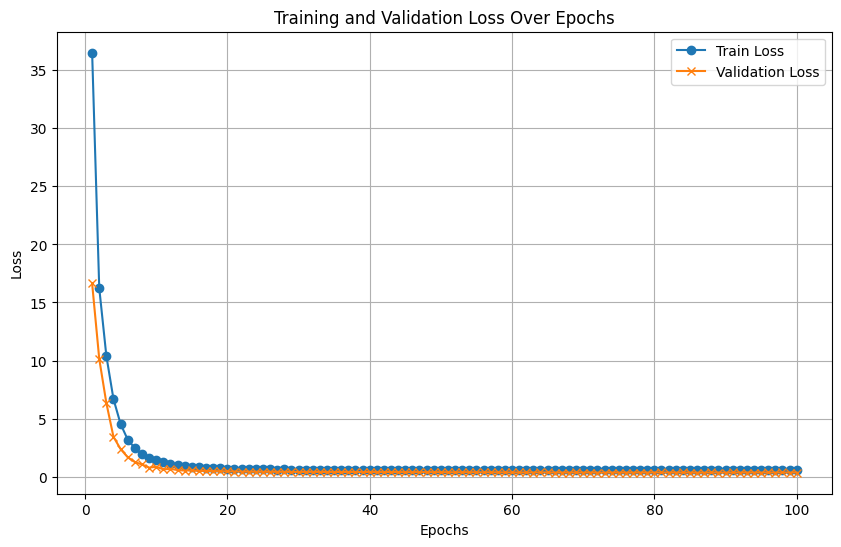

In [12]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

# Assuming `features_tensor` and `target_tensor` are prepared and available
condition_dim = y_train_tensor.shape[1]  # Example: number of classes or other categorical input
input_dim = features_tensor.shape[1]
latent_dim = 100
beta = 0.4

# Define the VAE model (ensure that your model can handle `condition_dim` as input)
vae = VAE(input_dim, latent_dim, condition_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)

optimizer = optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)
reconstruction_loss_fn1 = nn.MSELoss(reduction="mean")
reconstruction_loss_fn2 = nn.L1Loss(reduction='mean')
reconstruction_loss_fn = nn.SmoothL1Loss(reduction='mean')

# Define the VAE loss function
def vae_loss(reconstructed_x, x, mu, log_var, beta=1.0):
    reconstruction_loss = reconstruction_loss_fn(reconstructed_x, x)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + beta * kl_divergence  # Apply beta scaling




# Convert to TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Training loop
num_epochs = 100  # Adjust epochs for demonstration
train_losses = []
val_losses = []


patience = 10  # Number of epochs without improvement before stopping
best_loss = float('inf')  # Initialize the best loss to infinity
epochs_without_improvement = 0 

for epoch in tqdm(range(num_epochs)):
    # Training phase
    vae.train()
    epoch_train_loss = 0
    for batch in train_loader:
        features, conditions = batch
        features = features.to(device)
        conditions = conditions.to(device)
        reconstructed_x, mu, log_var = vae(features, conditions)

        loss = vae_loss(reconstructed_x, features, mu, log_var, beta)
        epoch_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(epoch_train_loss)
    if epoch_train_loss < best_loss:
        best_loss = epoch_train_loss
        epochs_without_improvement = 0  # Reset counter
        # Save model checkpoint when there's an improvement
        torch.save(vae.state_dict(), "best_vae_lrelu_model.pth")
    else:
        epochs_without_improvement += 1

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_train_loss:.4f}")

    # Validation phase
    vae.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            features, conditions = batch
            features = features.to(device)
            conditions = conditions.to(device)
            reconstructed_x, mu, log_var = vae(features, conditions)

            loss = vae_loss(reconstructed_x, features, mu, log_var)
            epoch_val_loss += loss.item()

    val_losses.append(epoch_val_loss)

    tqdm.write(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
import torch

# Reinitialize the VAE with the same architecture as used during training
vae = VAE(input_dim, latent_dim, condition_dim)  # Ensure these dimensions match your training setup
vae.load_state_dict(torch.load("best_vae_lrelu_model.pth"))
vae.eval()  # Set the model to evaluation mode
vae.to(device)  

/tmp/ipykernel_347164/585296845.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("best_vae_lrelu_model.pth"))


VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=15, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=128, bias=True)
    (fc_mean): Linear(in_features=128, out_features=100, bias=True)
    (fc_log_var): Linear(in_features=128, out_features=100, bias=True)
    (LeakyRelu): LeakyReLU(negative_slope=0.01)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=101, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=512, bias=True)
    (fc_output): Linear(in_features=512, out_features=14, bias=True)
    (lrelu): LeakyReLU(negative_slope=0.01)
    (sigmoid): Sigmoid()
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [14]:
import torch

# Number of samples to generate
num_samples = 1000

# Sample from a standard normal distribution (mean=0, std=1) in the latent space
z = torch.randn(num_samples, latent_dim).to(device)

# Provide conditional input if the model is conditional (e.g., class labels, other inputs)
# Replace `condition_tensor` with appropriate conditional data for your problem
conditions = torch.randint(0, condition_dim, (num_samples,)).to(device)  # Example: random class labels
conditions = torch.nn.functional.one_hot(conditions, num_classes=condition_dim).float()  # One-hot encode if needed

# Generate synthetic data
with torch.no_grad():
    # vae.  # Disable gradient computation
    generated_data = vae.decoder(z, conditions)  # Use the decoder to generate data


0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
     ... 
95    0.0
96    1.0
97    1.0
98    1.0
99    1.0
Name: Feature_0, Length: 100, dtype: float32


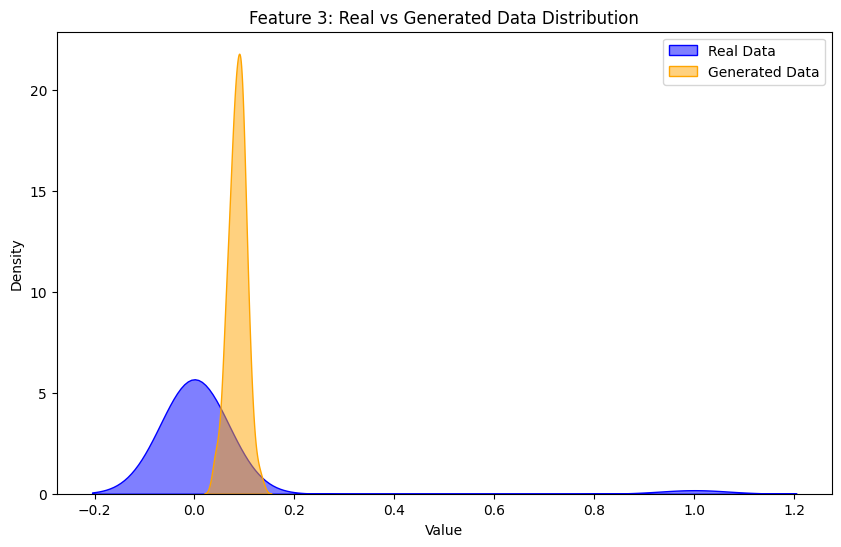

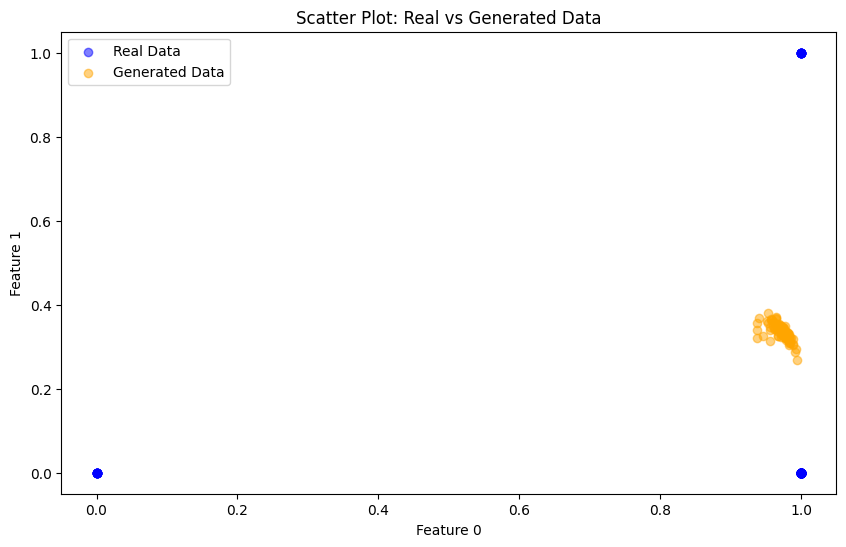

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you have real data (X_real) and generated data (X_generated) as NumPy arrays
X_real_np = X_train_tensor.cpu().numpy()[:100]  # Sample 100 real data points
X_generated_np = generated_data.cpu().numpy()[:100]  # Sample 100 generated data points

# Convert to pandas DataFrame for easier plotting
real_df = pd.DataFrame(X_real_np, columns=[f"Feature_{i}" for i in range(X_real_np.shape[1])])
gen_df = pd.DataFrame(X_generated_np, columns=[f"Feature_{i}" for i in range(X_generated_np.shape[1])])

# Plot the distributions of a single feature for both real and generated data
feature_idx = 3  # Change this to plot a specific feature
print(real_df[f"Feature_0"])
plt.figure(figsize=(10, 6))
sns.kdeplot(real_df[f"Feature_{feature_idx}"], label="Real Data", color="blue", fill=True, alpha=0.5)
sns.kdeplot(gen_df[f"Feature_{feature_idx}"], label="Generated Data", color="orange", fill=True, alpha=0.5)
plt.title(f"Feature {feature_idx}: Real vs Generated Data Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# Alternatively, scatter plot for two features
plt.figure(figsize=(10, 6))
plt.scatter(real_df[f"Feature_0"], real_df[f"Feature_1"], label="Real Data", color="blue", alpha=0.5)
plt.scatter(gen_df[f"Feature_0"], gen_df[f"Feature_1"], label="Generated Data", color="orange", alpha=0.5)
plt.title("Scatter Plot: Real vs Generated Data")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend()
plt.show()


In [16]:
from torch.nn.functional import mse_loss
device = generated_data.device
loss = mse_loss(generated_data[:100].to(device), X_train_tensor[:100].to(device),reduction='mean')
print(f"Reconstruction Loss (MSE): {loss.item()}")

Reconstruction Loss (MSE): 0.5316526889801025
